In [7]:
import os
import re
from collections import defaultdict

In [8]:
log_filename = "output_messages.txt"
#log_filename = "transport_output_messages.txt"
#log_filename = "inertial_output_messages.txt"
#log_filename = "out_iranian_dis80_50_05_02_transport_classic.txt"
#log_filename = "out_spain_50_prec100_nophases_transport_classic.txt"
dim = 15,15
patt_out_line = "\{\((?P<x>\w+),(?P<y>\w+)\).*<(?P<state>[\w,. -]+)>"

In [9]:
COLOR_SUSCEPTIBLE = "#3498db"
COLOR_INFECTED = "#e74c3c"
COLOR_RECOVERED = "#2ecc71"
COLOR_DECEASED = "#8ba2ad"

In [10]:
"""def time_str_to_ts(time_str):
  patt_time = "([0-9]{2}):([0-9]{2}):([0-9]{2}):([0-9]{3})"
  match = re.match(patt_time, time_str)
  if not match:
    raise RuntimeError("Error converting simulation time")
  tu = list(map(int, match.groups()))
  return tu[3] + tu[2]*1000 + tu[1]*60000 + tu[0]*3600000"""

def curr_states_to_df_row(sim_time, curr_states):
    sus_acc = 0
    inf_acc = 0
    rec_acc = 0
    dec_acc = 0
    for i in range(len(curr_states)):
        for j in range(len(curr_states[0])):
            #print(curr_states[i][j])
            sus, inf, rec, dec = curr_states[i][j]
            sus_acc += sus
            inf_acc += inf
            rec_acc += rec
            dec_acc += dec
            
            #print(sus, inf, rec, dec, sus + inf + rec + dec)
            assert 0.99 <= sus + inf + rec + dec < 1.01, (curr_time, i, j, sus + inf + rec + dec)
            
    num_cells = len(curr_states) * len(curr_states[0])
    sus_acc /= num_cells
    inf_acc /= num_cells
    rec_acc /= num_cells
    dec_acc /= num_cells
    
    assert 0.999 <= sus_acc + inf_acc + rec_acc + dec_acc < 1.001, (curr_time, sus_acc + inf_acc + rec_acc + dec_acc)
    
    return [int(sim_time), sus_acc, inf_acc, rec_acc, dec_acc]

In [11]:
curr_time = None
curr_states = []

for _ in range(dim[0]):
    curr_states.append([])
    for _ in range(dim[1]):
        curr_states[-1].append([1, 0, 0, 0])

In [12]:
states = ["sus", "infec", "rec", "dec"]
data = []
curr_data = []

with open(log_filename, "r") as log_file:
    for line in log_file:
        line = line.strip()
        if line.isnumeric() and line != curr_time:
            curr_time = line
            data.append(curr_states_to_df_row(curr_time, curr_states))
            continue

        #print(line)
        match = re.search(patt_out_line, line)
        if not match:
            print(line)
            continue

        x = int(match.group("x"))
        y = int(match.group("y"))

        state = list(map(float, match.group("state").split(",")[-4:]))
        #print("Modifying %d,%d" % (x,y), state)
        curr_states[x][y] = state
        
    data.append(curr_states_to_df_row(curr_time, curr_states))

0


In [13]:
data[:5]

[[0, 1.0, 0.0, 0.0, 0.0],
 [1, 0.9993333333333333, 0.0006666666666666666, 0.0, 0.0],
 [2, 0.998822666666666, 0.0007306666666666666, 0.0004000000000000001, 2e-05],
 [3,
  0.998246666666666,
  0.0008444444444444444,
  0.0008391111111111111,
  4.31111111111111e-05],
 [4,
  0.9975417777777772,
  0.001012888888888889,
  0.0013475555555555554,
  7.111111111111109e-05]]

### Visualization

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [15]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [16]:
columns = ["time", "susceptible", "infected", "recovered", "deceased"]
df_vis = pd.DataFrame(data, columns=columns)
df_vis = df_vis.set_index("time")
df_vis.to_csv("states.csv")
df_vis.head()

,susceptible,infected,recovered,deceased
time,,,,
0,1.000000,0.000000,0.000000,0.000000
1,0.999333,0.000667,0.000000,0.000000
2,0.998823,0.000731,0.000400,0.000020
3,0.998247,0.000844,0.000839,0.000043
4,0.997542,0.001013,0.001348,0.000071


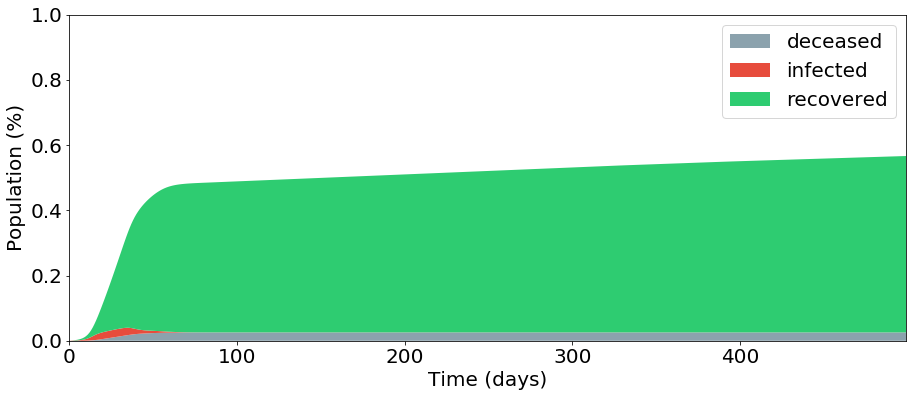

In [23]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["deceased", "infected", "recovered"]
colors=[COLOR_DECEASED, COLOR_INFECTED, COLOR_RECOVERED]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(15,6))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.ylim((0,1))
plt.savefig(base_name + "_area.png")
plt.savefig(base_name + "_area.pdf")

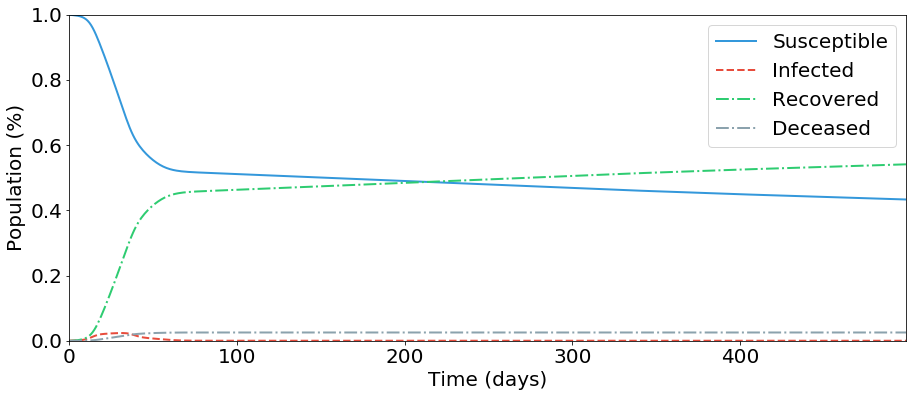

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["infected"], label="Infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
ax.plot(x, df_vis["deceased"], label="Deceased", color=COLOR_DECEASED, linewidth=linewidth, linestyle="-.")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_lines.png")
plt.savefig(base_name + "_lines.pdf")

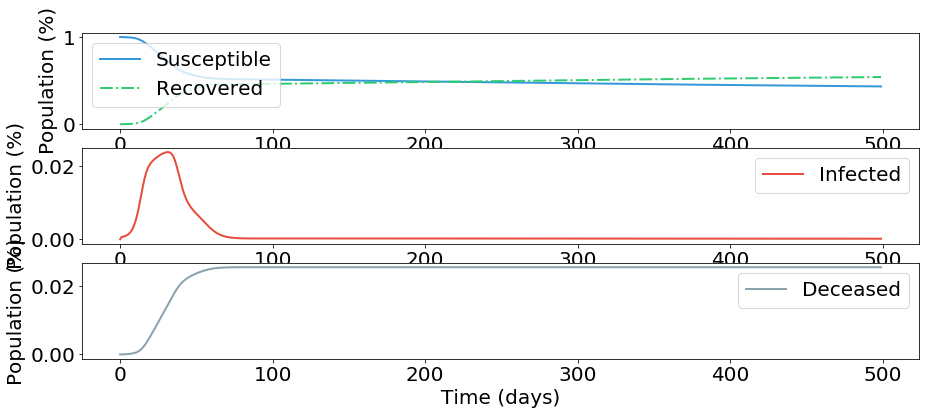

In [21]:
fig, axs = plt.subplots(3, figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
axs[0].plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
axs[0].plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
axs[0].set(ylabel='Population (%)')
axs[0].legend()

axs[1].plot(x, df_vis["infected"], label="Infected", color=COLOR_INFECTED, linewidth=linewidth)
axs[1].set(xlabel='Time (days)', ylabel='Population (%)')
axs[1].legend()

axs[2].plot(x, df_vis["deceased"], label="Deceased", color=COLOR_DECEASED, linewidth=linewidth)
axs[2].set(xlabel='Time (days)', ylabel='Population (%)')
axs[2].legend()
#plt.legend(loc='upper right')
#plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.xlabel("Time (days)")
#plt.ylabel("Population (%)")
#plt.savefig(base_name + "_lines.png")
#plt.savefig(base_name + "_lines.pdf")
plt.savefig(base_name + "_lines_sep.png")
plt.savefig(base_name + "_lines_sep.pdf")

In [20]:
df_vis.to_pickle(base_name + ".pickle")